In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap

# Define a cleaning function for the dataset
def clean_fire_data(df):
    # Drop rows where essential columns like 'YEAR_' or 'GIS_ACRES' are missing
    df = df.dropna(subset=['YEAR_', 'GIS_ACRES'])
    
    # Convert 'YEAR_' to integer for easier analysis
    df['YEAR_'] = df['YEAR_'].astype(int)
    
    # Convert date columns to datetime for better handling
    for date_col in ['ALARM_DATE', 'CONT_DATE']:
        df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    
    # Drop columns with excessive missing data or limited utility
    columns_to_drop = ['COMMENTS', 'COMPLEX_NAME', 'IRWINID', 'COMPLEX_ID', 'FIRE_NUM']
    df = df.drop(columns=columns_to_drop)
    
    # Fill missing 'AGENCY', 'UNIT_ID', and 'FIRE_NAME' with placeholder text
    df['AGENCY'] = df['AGENCY'].fillna('Unknown')
    df['UNIT_ID'] = df['UNIT_ID'].fillna('Unknown')
    df['FIRE_NAME'] = df['FIRE_NAME'].fillna('Unnamed Fire')
    
    # Ensure other categorical columns have consistent formatting (e.g., string types)
    df['STATE'] = df['STATE'].astype(str)
    
    return df

# Note: Effectiveness is defined as how quickly the acreage was contained relative to size. 
# This formula will be the basis of the analysis wizard.

# Load the dataset
file_path = './Resources/California_Fire_Perimeters_(all).csv'
fire_data = pd.read_csv(file_path)

# Clean the dataset
cleaned_fire_data = clean_fire_data(fire_data)



C:\Users\ntrie\AppData\Local\Temp\ipykernel_77212\2635651987.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['YEAR_'] = df['YEAR_'].astype(int)
C:\Users\ntrie\AppData\Local\Temp\ipykernel_77212\2635651987.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
C:\Users\ntrie\AppData\Local\Temp\ipykernel_77212\2635651987.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

In [11]:
# Calculate effectiveness and rank containment methods
cleaned_fire_data['Containment_Duration'] = (cleaned_fire_data['CONT_DATE'] - cleaned_fire_data['ALARM_DATE']).dt.total_seconds() / 3600  # in hours
cleaned_fire_data['Effectiveness'] = cleaned_fire_data['GIS_ACRES'] / cleaned_fire_data['Containment_Duration']

# Group by containment method and calculate mean effectiveness
method_effectiveness = cleaned_fire_data.groupby('C_METHOD').agg(
    Average_Effectiveness=('Effectiveness', 'mean'),
    Count=('Effectiveness', 'count')
).sort_values(by='Average_Effectiveness', ascending=False)

# Display the results
print(method_effectiveness)

          Average_Effectiveness  Count
C_METHOD                              
1.0                         inf   3844
2.0                         inf    585
3.0                         inf    235
4.0                         inf    208
5.0                         inf    112
6.0                         inf   1034
7.0                         inf    922
8.0                         inf   2576


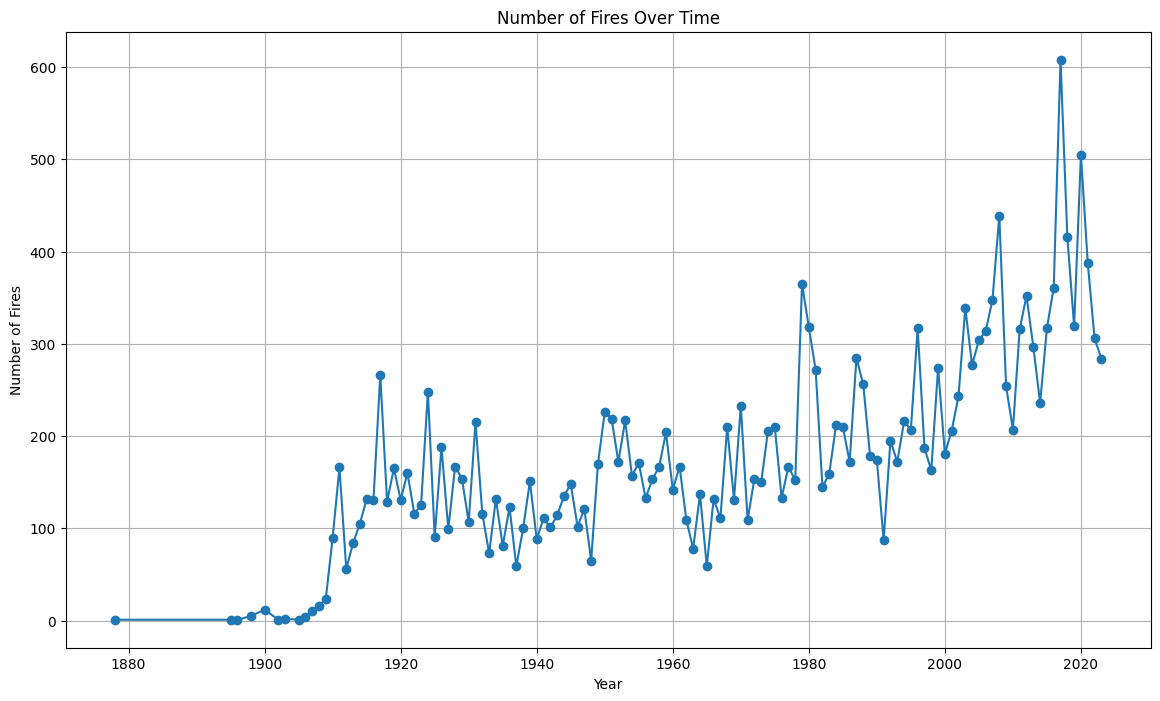

Peak Years for Fires:
YEAR_
2017    608
2020    505
2008    439
2018    416
2021    388
dtype: int64


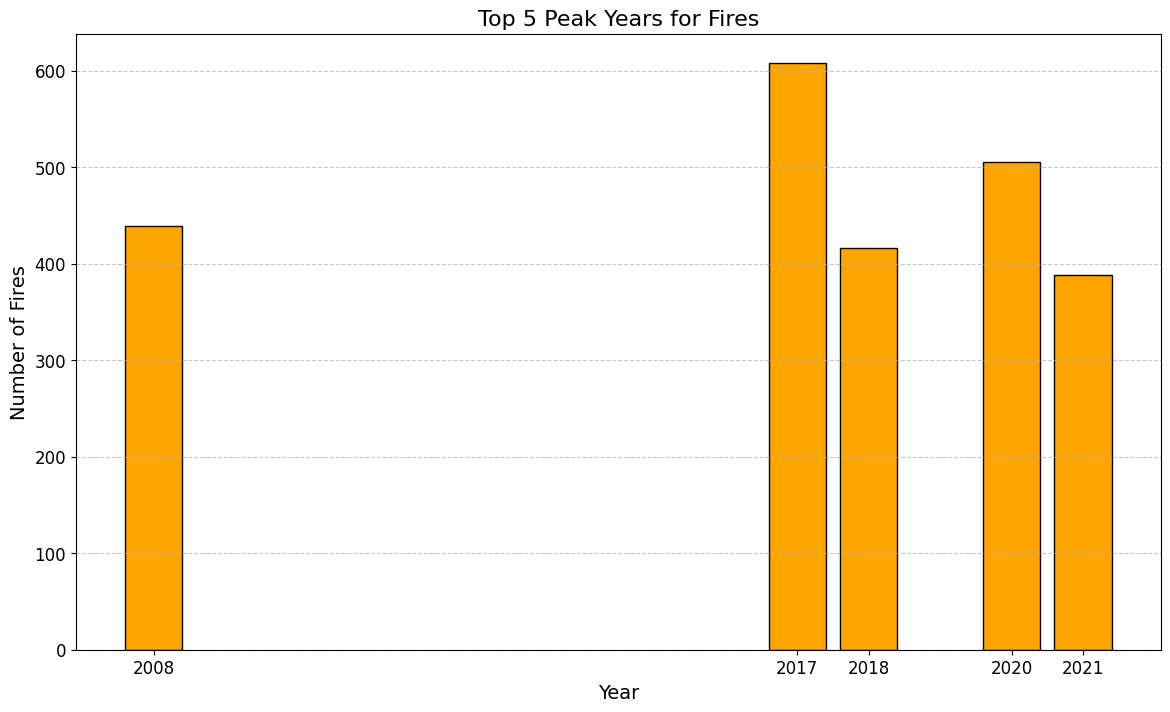

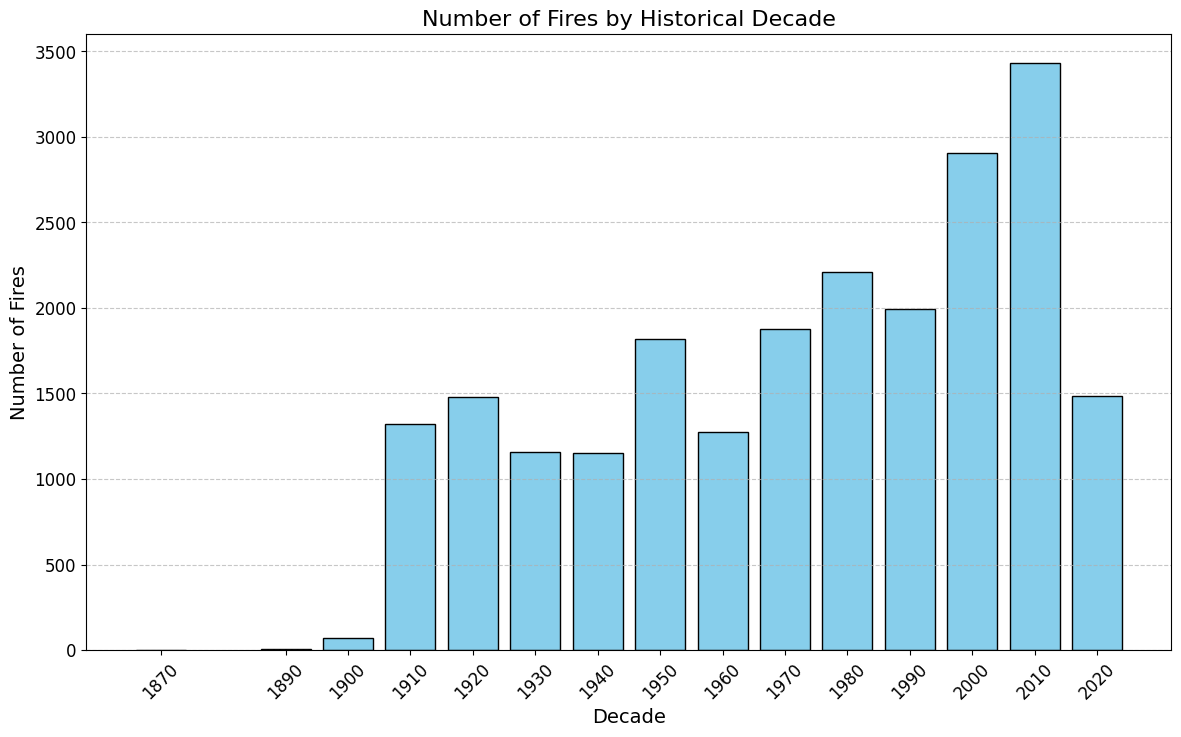

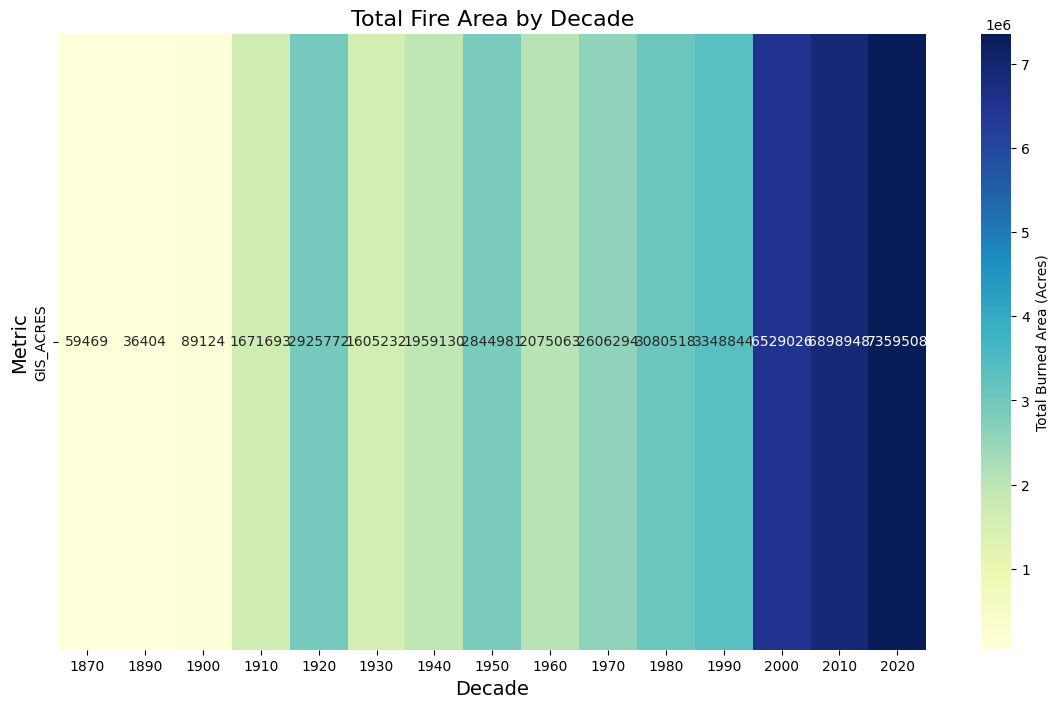

<class 'pandas.core.frame.DataFrame'>
Index: 22184 entries, 0 to 22183
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   OBJECTID              22184 non-null  int64              
 1   YEAR_                 22184 non-null  int32              
 2   STATE                 22184 non-null  object             
 3   AGENCY                22184 non-null  object             
 4   UNIT_ID               22184 non-null  object             
 5   FIRE_NAME             22184 non-null  object             
 6   INC_NUM               21281 non-null  object             
 7   ALARM_DATE            16865 non-null  datetime64[ns, UTC]
 8   CONT_DATE             9632 non-null   datetime64[ns, UTC]
 9   CAUSE                 22160 non-null  float64            
 10  C_METHOD              10072 non-null  float64            
 11  OBJECTIVE             21937 non-null  float64            
 12  GIS_ACRES

In [12]:
# Plot the number of fires over time
fires_per_year = cleaned_fire_data.groupby('YEAR_').size()
plt.figure(figsize=(14, 8))
plt.plot(fires_per_year.index, fires_per_year.values, marker='o')
plt.title('Number of Fires Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Fires')
plt.grid(True)
plt.show()

# Identify peak years for fires
peak_years = fires_per_year.sort_values(ascending=False).head(5)
print("Peak Years for Fires:")
print(peak_years)

# Plot the peak years for fires
peak_years_sorted = peak_years.sort_index()
plt.figure(figsize=(14, 8))
plt.bar(peak_years_sorted.index, peak_years_sorted.values, color='orange', edgecolor='black')
plt.title('Top 5 Peak Years for Fires', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Fires', fontsize=14)
plt.xticks(peak_years_sorted.index, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot the number of fires by decade
cleaned_fire_data['Decade'] = (cleaned_fire_data['YEAR_'] // 10) * 10
fires_by_decade = cleaned_fire_data.groupby('Decade').size()
plt.figure(figsize=(14, 8))
plt.bar(fires_by_decade.index, fires_by_decade.values, color='skyblue', edgecolor='black', width=8)
plt.title('Number of Fires by Historical Decade', fontsize=16)
plt.xlabel('Decade', fontsize=14)
plt.ylabel('Number of Fires', fontsize=14)
plt.xticks(fires_by_decade.index, fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Heatmap: Total fire area by decade
fire_area_by_decade = cleaned_fire_data.groupby('Decade')['GIS_ACRES'].sum().reset_index()
plt.figure(figsize=(14, 8))
sns.heatmap(fire_area_by_decade.set_index('Decade').T, annot=True, fmt='.0f', cmap='YlGnBu', cbar_kws={'label': 'Total Burned Area (Acres)'})
plt.title('Total Fire Area by Decade', fontsize=16)
plt.xlabel('Decade', fontsize=14)
plt.ylabel('Metric', fontsize=14)
plt.show()

# Display basic information
print(cleaned_fire_data.info())
print(cleaned_fire_data.head())




In [15]:
# Cause data analysis
if 'CAUSE' in cleaned_fire_data.columns:
    cause_counts = cleaned_fire_data['CAUSE'].value_counts()
    print("Cause Data Analysis:")
    print(cause_counts)
else:
    print("Cause column is missing in the dataset.")

# Display basic information
print(cleaned_fire_data.info())
print(cleaned_fire_data.head())

Cause Data Analysis:
CAUSE
14.0    9908
1.0     3516
9.0     3470
2.0     1349
7.0      954
5.0      764
10.0     558
11.0     454
4.0      397
3.0      339
8.0      192
18.0     103
6.0       79
15.0      29
19.0      17
16.0      15
13.0      11
12.0       5
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 22184 entries, 0 to 22183
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   OBJECTID              22184 non-null  int64              
 1   YEAR_                 22184 non-null  int32              
 2   STATE                 22184 non-null  object             
 3   AGENCY                22184 non-null  object             
 4   UNIT_ID               22184 non-null  object             
 5   FIRE_NAME             22184 non-null  object             
 6   INC_NUM               21281 non-null  object             
 7   ALARM_DATE            16865 non-null 